**Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

**Linear Regression**

Fold 1
  Train R²: 0.6040
  Train MSE: 126.88
  Test  R²: 0.6026
  Test  MSE: 126.77

Fold 2
  Train R²: 0.6056
  Train MSE: 126.66
  Test  R²: 0.5961
  Test  MSE: 127.63

Fold 3
  Train R²: 0.6036
  Train MSE: 126.42
  Test  R²: 0.6044
  Test  MSE: 128.63

Fold 4
  Train R²: 0.6028
  Train MSE: 126.81
  Test  R²: 0.6076
  Test  MSE: 127.09

Fold 5
  Train R²: 0.6040
  Train MSE: 127.12
  Test  R²: 0.6028
  Test  MSE: 125.80

Cross-Validation Summary:
Average Train R²: 0.6040
Average Train MSE: 126.78
Average Test  R²: 0.6027
Average Test  MSE: 127.18
Best Fold Test R²: 0.6076

Top 15 Important Features from Best Model:
                        Feature  Coefficient
72          track_genre_iranian   -35.774444
106         track_genre_romance   -34.884326
37   track_genre_detroit-techno   -32.340691
26    track_genre_chicago-house   -31.609218
33            track_genre_dance    31.452020
103            track_genre_rock    30.290802
79             track_genre_kids   -29.466261
55        tr

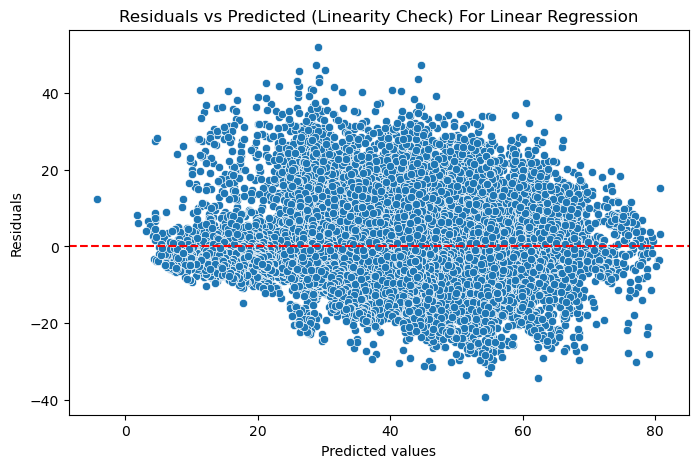

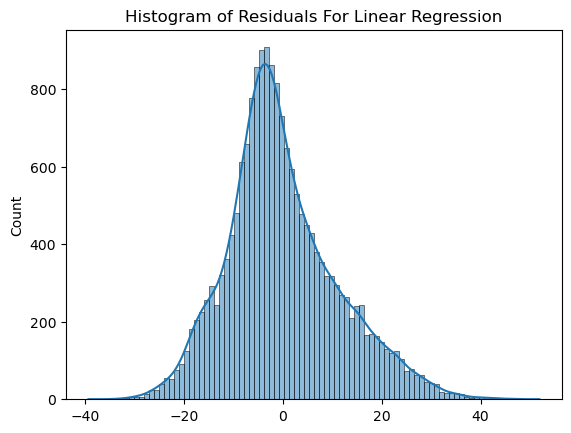

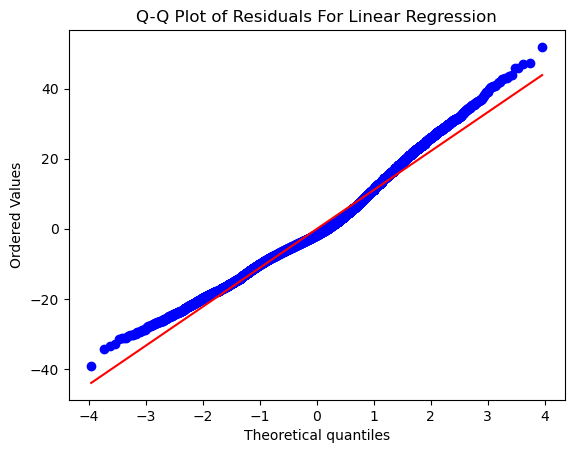

C:\Users\VincentX\AppData\Local\Temp\ipykernel_15792\3236880264.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette='viridis')


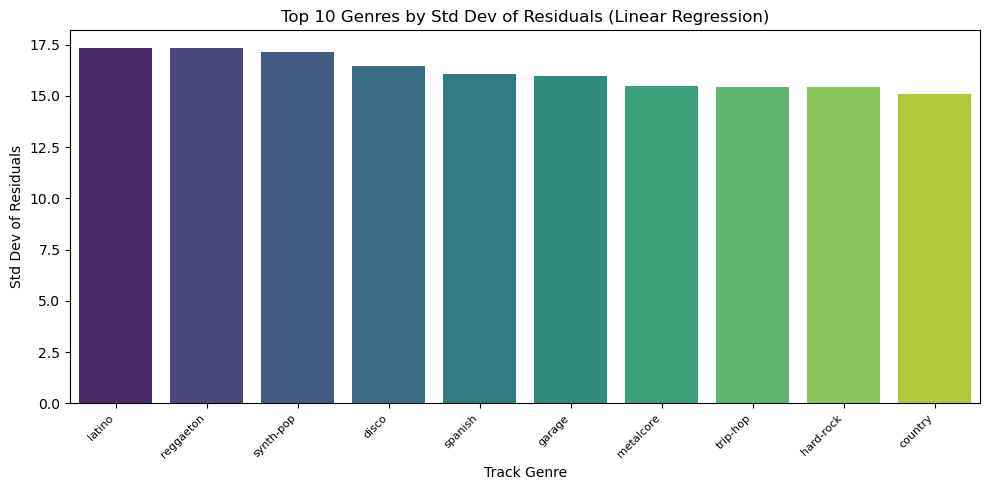

In [ ]:
df = pd.read_csv('Cleaned_Dataset.csv')

df = df.drop(columns=['Unnamed: 0', 'release_date', 'track_id', 'artists', 'album_name', 'track_name'])

df = pd.get_dummies(df, columns=['track_genre'], drop_first=True)

X = df.drop(columns=['popularity'])
y = df['popularity']

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_array = X.values
y_array = y.values
feature_names = X.columns

train_r2_scores = []
train_mse_scores = []
test_r2_scores = []
test_mse_scores = []

best_model = None
best_test_r2 = -np.inf
best_coef = None

fold = 1
for train_index, test_index in kf.split(X_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    print(f"Fold {fold}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Train MSE: {train_mse:.2f}")
    print(f"  Test  R²: {test_r2:.4f}")
    print(f"  Test  MSE: {test_mse:.2f}")
    print()

    train_r2_scores.append(train_r2)
    train_mse_scores.append(train_mse)
    test_r2_scores.append(test_r2)
    test_mse_scores.append(test_mse)

    if test_r2 > best_test_r2:
        best_test_r2 = test_r2
        best_model = model
        best_coef = model.coef_

    fold += 1

print("Cross-Validation Summary:")
print(f"Average Train R²: {np.mean(train_r2_scores):.4f}")
print(f"Average Train MSE: {np.mean(train_mse_scores):.2f}")
print(f"Average Test  R²: {np.mean(test_r2_scores):.4f}")
print(f"Average Test  MSE: {np.mean(test_mse_scores):.2f}")
print(f"Best Fold Test R²: {best_test_r2:.4f}")

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_coef,
    'Abs_Coefficient': np.abs(best_coef)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("\nTop 15 Important Features from Best Model:")
print(coef_df[['Feature', 'Coefficient']].head(15))

residuals = y_test - y_test_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Linearity Check) For Linear Regression")
plt.show()

sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals For Linear Regression")
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For Linear Regression")
plt.show()

df_full = pd.read_csv('Cleaned_Dataset.csv')

df_full = df_full.drop(columns=['Unnamed: 0', 'release_date', 'track_id', 'artists', 'album_name', 'track_name'])
df_full = pd.get_dummies(df_full, columns=['track_genre'], drop_first=True)

genre_col = pd.read_csv('Cleaned_Dataset.csv')['track_genre']

test_genres = genre_col.iloc[test_index].reset_index(drop=True)
residuals_df = pd.DataFrame({
    'residuals': residuals,
    'track_genre': test_genres
})

genre_std = residuals_df.groupby('track_genre')['residuals'].std().sort_values(ascending=False)

top10_genre_std = genre_std.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette='viridis')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (Linear Regression)")
plt.ylabel("Std Dev of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**Base Decision Tree With Bayesian Optimization (1 Hour Run)**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\VincentX\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.04, 'friedman_mse', 50, None, 5, 60] before, using random point [0.054899413923919484, 'squared_error', 41, 'sqrt', 1, 45]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\VincentX\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.04, 'friedman_mse', 50, None, 5, 60] before, using random point [0.047965075680341855, 'friedman_mse', 47, 'sqrt', 5, 56]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: OrderedDict({'model__ccp_alpha': 0.04982818325844533, 'model__criterion': 'friedman_mse', 'model__max_depth': 50, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 60})
Train R^2:                0.5714
Train MSE:                137.3225
Test R^2:                 0.5641
Test MSE:                 139.0729


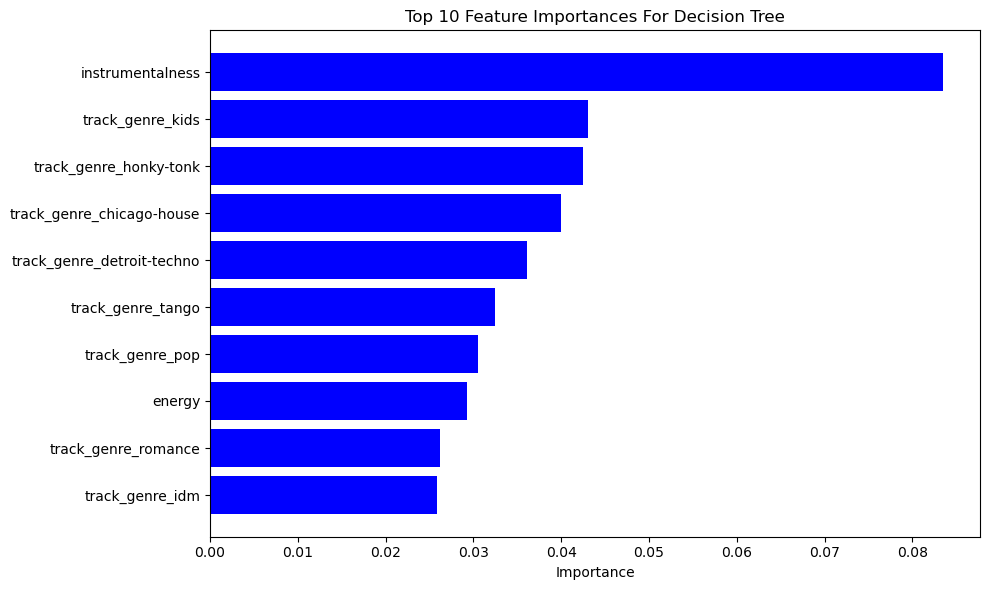

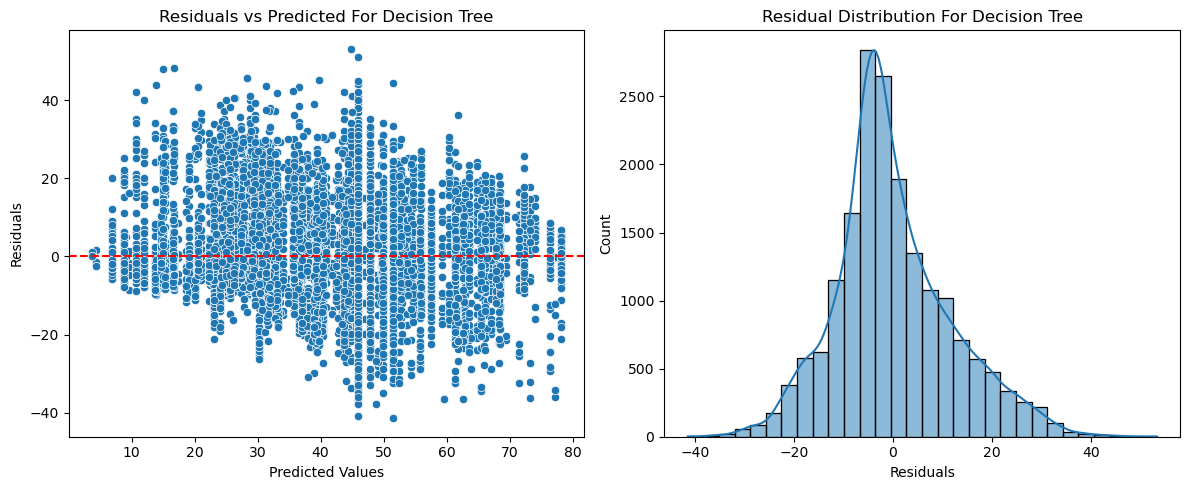

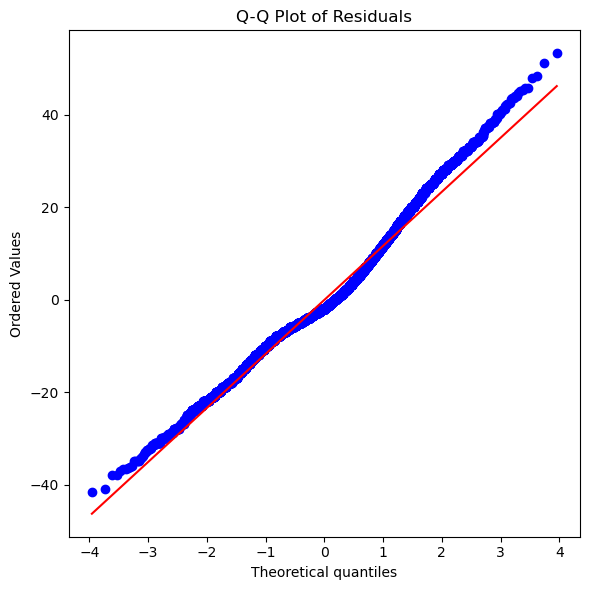

C:\Users\VincentX\AppData\Local\Temp\ipykernel_9212\2414485790.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="magma")


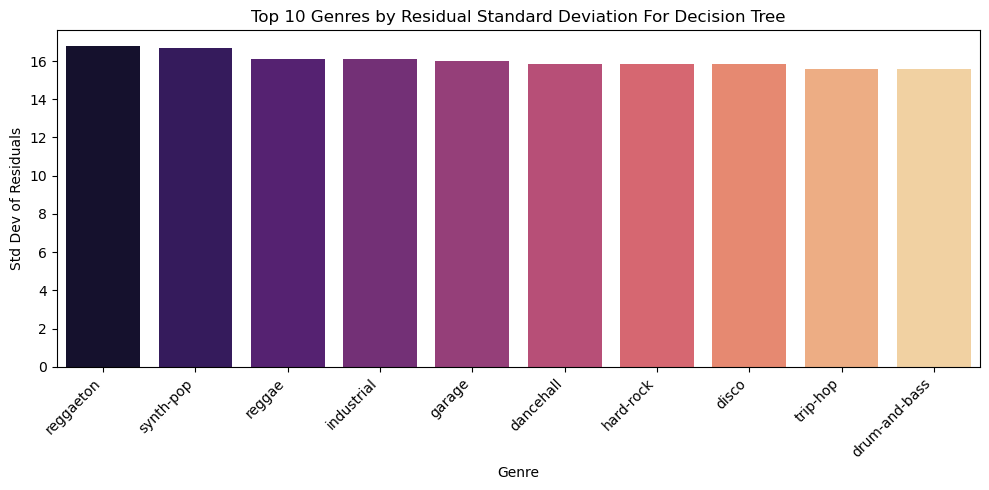

In [11]:
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

search_spaces = {
    'model__max_depth': Integer(30, 50),  
    'model__min_samples_split': Integer(40, 60),  
    'model__min_samples_leaf': Integer(1, 5),  
    'model__ccp_alpha': Real(0.04, 0.06),  
    'model__max_features': Categorical(['sqrt', None]),
    'model__criterion': Categorical(['squared_error', 'friedman_mse'])
}

opt = BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=30,  
    cv=5,       
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error',
    verbose=1
)
opt.fit(X_train, y_train)

y_train_pred = opt.predict(X_train)
y_test_pred = opt.predict(X_test)

print("Best Parameters:", opt.best_params_)
print(f"{'Train R^2:':25} {r2_score(y_train, y_train_pred):.4f}")
print(f"{'Train MSE:':25} {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"{'Test R^2:':25} {r2_score(y_test, y_test_pred):.4f}")
print(f"{'Test MSE:':25} {mean_squared_error(y_test, y_test_pred):.4f}")

best_tree = opt.best_estimator_.named_steps['model']
X_encoded = preprocessor.fit_transform(X_train)
ohe = preprocessor.named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = best_tree.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = [feature_names[i] for i in top_indices]

plt.figure(figsize=(10, len(top_indices) * 0.6))  
plt.barh(range(len(top_indices)), 
         top_importances, 
         align="center", 
         color="blue")  
plt.yticks(range(len(top_indices)), 
           top_features, 
           fontsize=10)
plt.title("Top 10 Feature Importances For Decision Tree", fontsize=12)
plt.xlabel("Importance", fontsize=10)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted For Decision Tree')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residual Distribution For Decision Tree')
plt.xlabel('Residuals')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

X_test_original = X_test.copy()
X_test_original['residuals'] = residuals
X_test_original['track_genre'] = X.loc[X_test.index]['track_genre'].values

genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)
top10_genre_std = genre_std.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="magma")
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Genres by Residual Standard Deviation For Decision Tree')
plt.ylabel('Std Dev of Residuals')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

**Random Forest With Bayesian Optimization (1 Hour Run)**

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

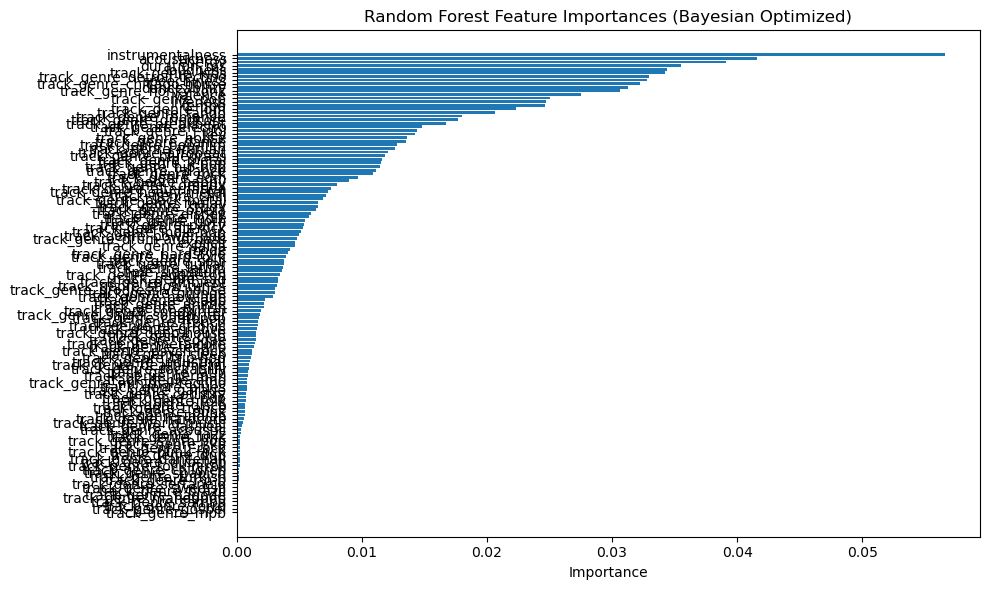

In [ ]:
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

search_space = {
    'model__n_estimators': Integer(100, 300),
    'model__max_depth': Integer(10, 40),
    'model__min_samples_leaf': Integer(1, 10),
    'model__min_samples_split': Integer(2, 10),
    'model__max_features': Categorical(['sqrt', 'log2'])
}

opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train, y_train)

best_pipeline = opt.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

print("Best Parameters:", opt.best_params_)
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))

rf_model = best_pipeline.named_steps['model']
ohe = best_pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = rf_model.feature_importances_
top_indices = np.argsort(importances)[-10:]  
top_indices_sorted = top_indices[np.argsort(importances[top_indices])]  

plt.figure(figsize=(10, 5))
plt.title("Top 10 Random Forest Feature Importances (Bayesian Optimized)")
plt.barh(range(len(top_indices_sorted)), importances[top_indices_sorted], align="center", color="blue")
plt.yticks(range(len(top_indices_sorted)), [feature_names[i] for i in top_indices_sorted], fontsize=9)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Random Forest**

Train R²: 0.7301472689432085
Test R²: 0.5885649677826684
Test MSE: 131.25767308572918
Train MSE: 86.46595280263114


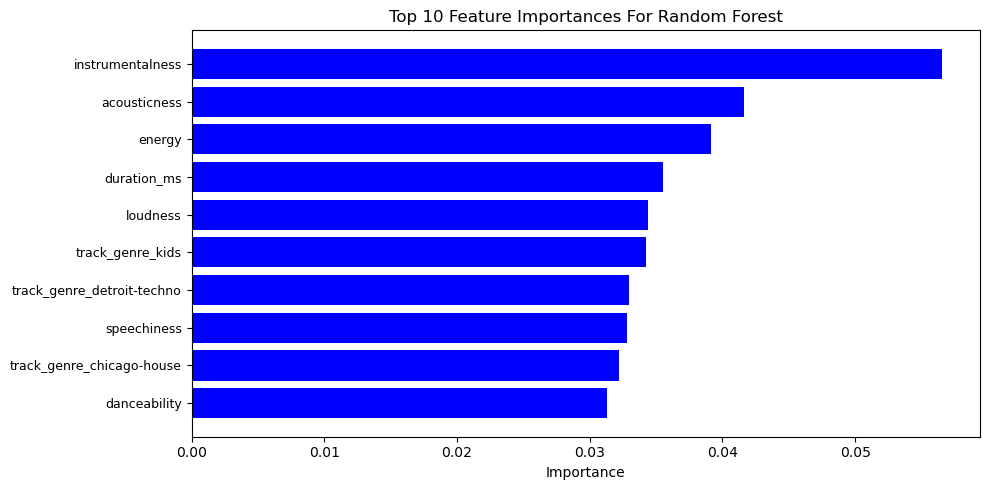

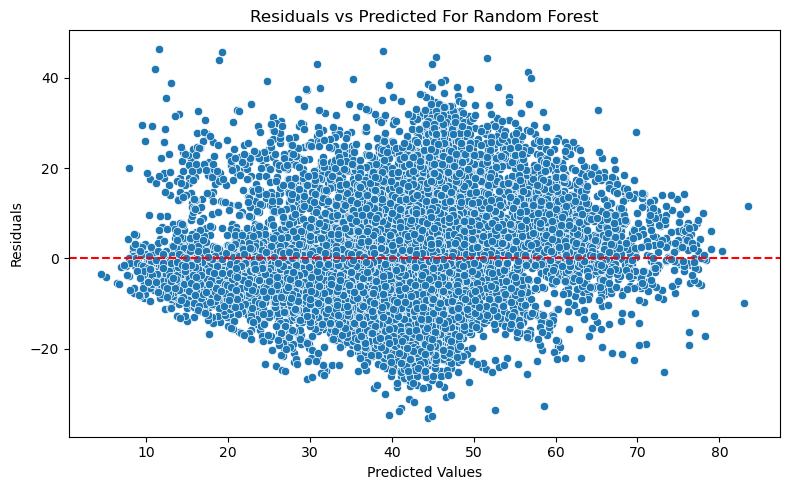

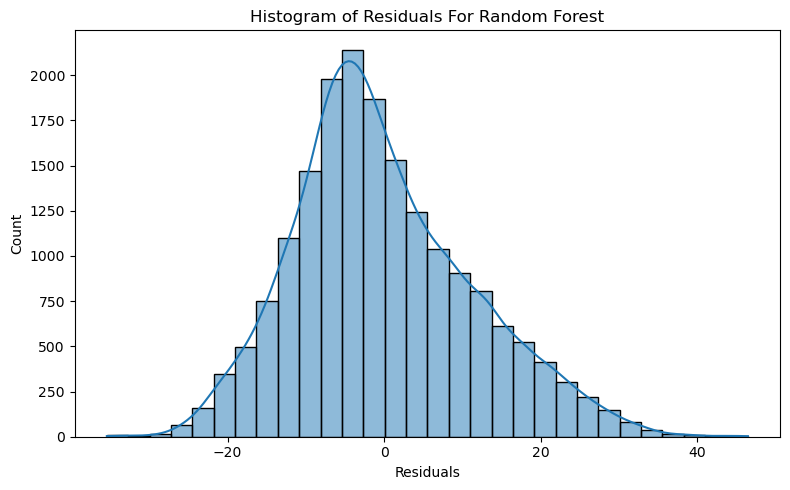

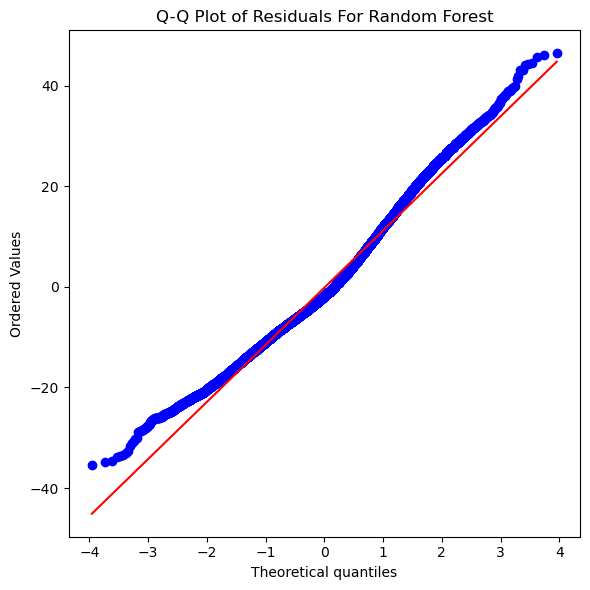

C:\Users\VincentX\AppData\Local\Temp\ipykernel_9212\3541526662.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="magma")


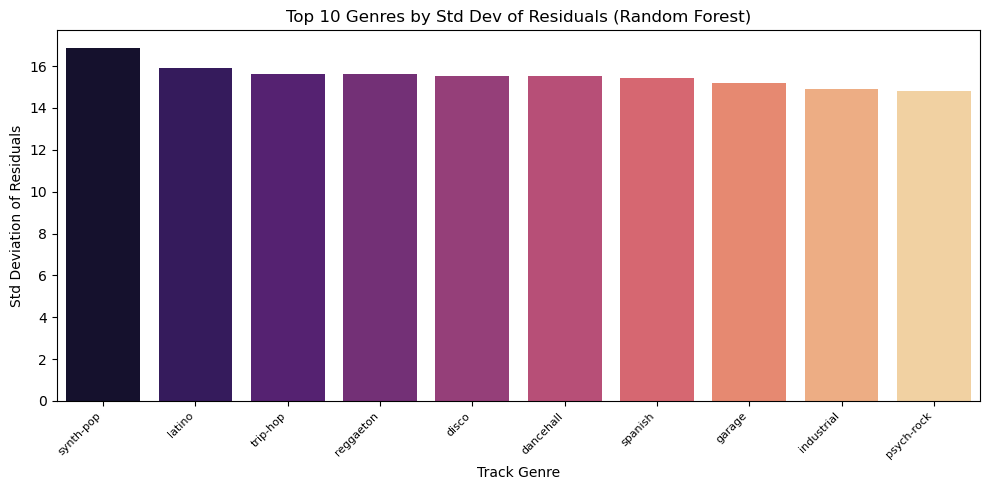

In [13]:
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']

X = df[numerical_features + categorical_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=40,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))

rf_model = pipeline.named_steps['model']
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  

top_indices_sorted = indices[np.argsort(importances[indices])]

plt.figure(figsize=(10, len(top_indices_sorted) * 0.5))  
plt.title("Top 10 Feature Importances For Random Forest")
plt.barh(range(len(top_indices_sorted)), importances[top_indices_sorted], align="center", color="blue")
plt.yticks(range(len(top_indices_sorted)), [feature_names[i] for i in top_indices_sorted], fontsize=9)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted For Random Forest")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals For Random Forest")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For Random Forest")
plt.tight_layout()
plt.show()

X_test_original = X_test.copy()
X_test_original['residuals'] = residuals
X_test_original['track_genre'] = X.loc[X_test.index]['track_genre'].values

genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)

top10_genre_std = genre_std.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="magma")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (Random Forest)")
plt.ylabel("Std Deviation of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**XGBoost**

XGBoost Results:
Train R²: 0.9214317202568054
Test R²: 0.6912040114402771
Test MSE: 98.51335792445596
Train MSE: 25.17478440667607


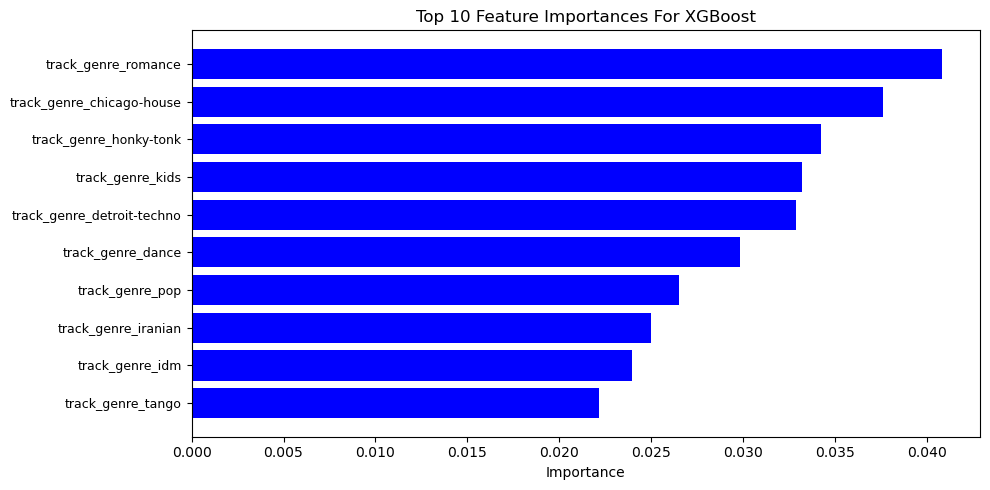

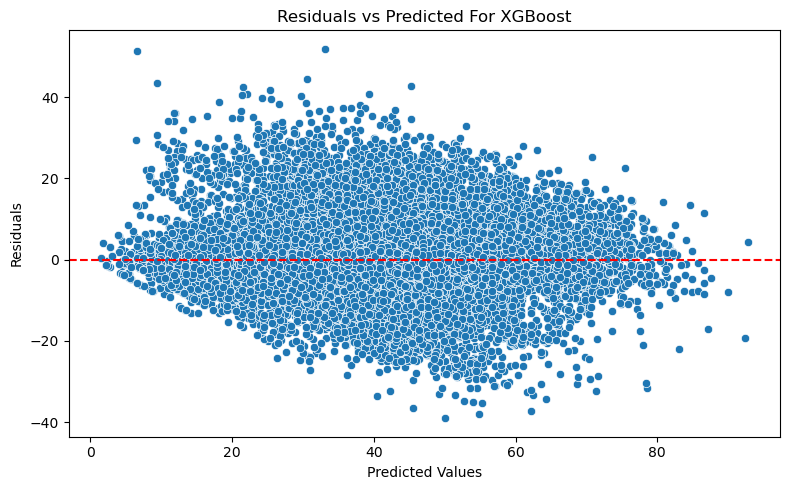

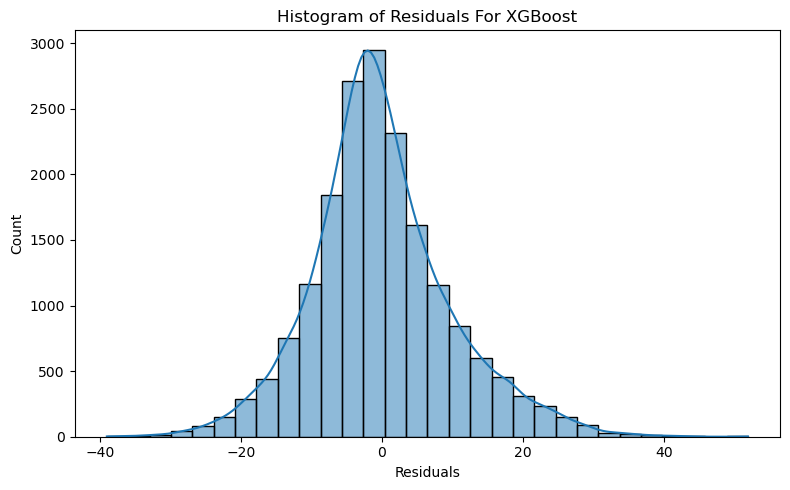

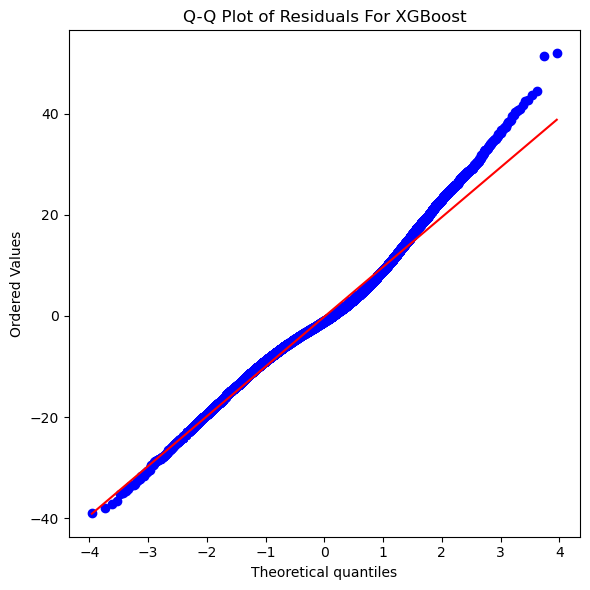

C:\Users\VincentX\AppData\Local\Temp\ipykernel_9212\3899415073.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="viridis")


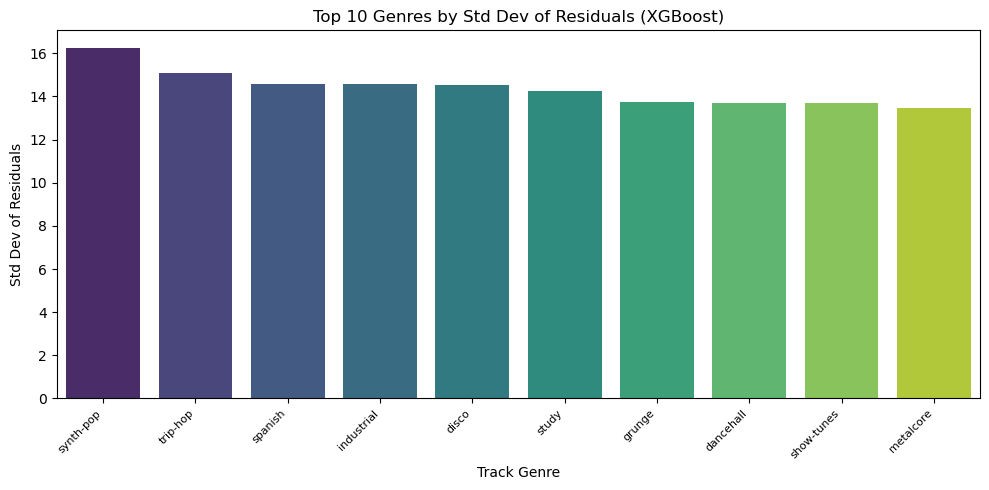

In [ ]:
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        colsample_bytree=0.5,
        learning_rate=0.07144343159553798,
        max_depth=15,
        n_estimators=500,
        reg_alpha=10.0,
        reg_lambda=10.0,
        subsample=0.5
    ))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

results = {
    "Train R²": r2_score(y_train, y_train_pred),
    "Test R²": r2_score(y_test, y_test_pred),
    "Test MSE": mean_squared_error(y_test, y_test_pred),
    "Train MSE": mean_squared_error(y_train, y_train_pred)
}

xgb_model = pipeline.named_steps['model']
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[-10:]  

top_indices_sorted = indices[np.argsort(importances[indices])]

print("XGBoost Results:")
for key, value in results.items():
    print(f"{key}: {value}")

plt.figure(figsize=(10, len(top_indices_sorted) * 0.5))  
plt.title("Top 10 Feature Importances For XGBoost")
plt.barh(range(len(top_indices_sorted)), importances[top_indices_sorted], align="center", color="blue")
plt.yticks(range(len(top_indices_sorted)), [feature_names[i] for i in top_indices_sorted], fontsize=9)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted For XGBoost")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals For XGBoost")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For XGBoost")
plt.tight_layout()
plt.show()

X_test_original = X_test.copy()
X_test_original['residuals'] = residuals
X_test_original['track_genre'] = X.loc[X_test.index]['track_genre'].values

genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)

top10_genre_std = genre_std.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="viridis")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (XGBoost)")
plt.ylabel("Std Dev of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**Bagged Forest with Bayesian Optimization (30 Min Run)**

C:\Users\xayas\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagged Forest Results:
Best Parameters: OrderedDict([('model__base_estimator__max_depth', 30), ('model__base_estimator__min_samples_leaf', 4), ('model__n_estimators', 76)])
Train R²: 0.5827983107198438
Test R²: 0.5208868856796988
Test MSE: 152.84860939435237


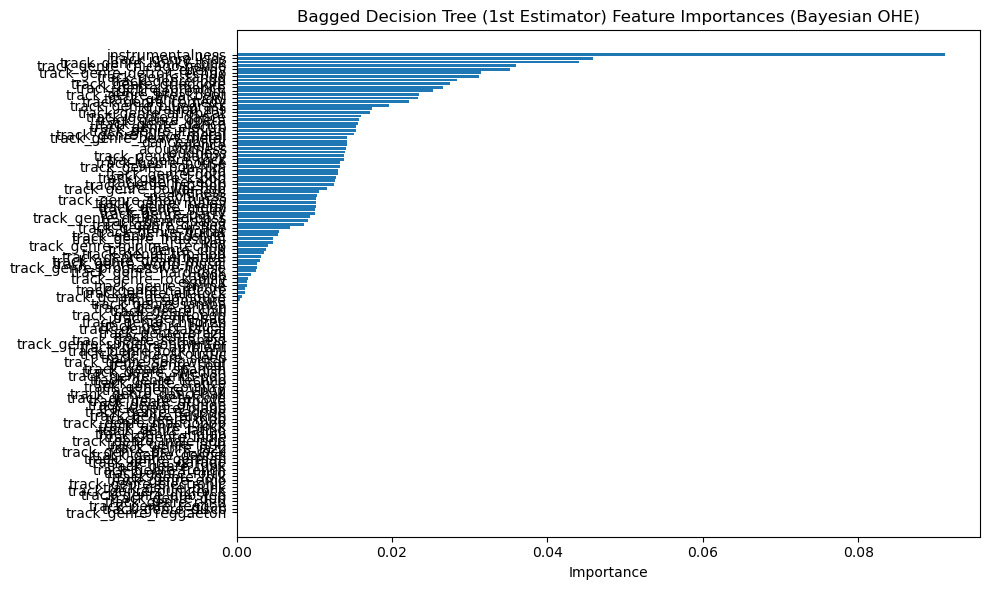

In [ ]:
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', BaggingRegressor(
        base_estimator=DecisionTreeRegressor(random_state=42),
        random_state=42,
        n_jobs=-1
    ))
])

search_spaces = {
    'model__n_estimators': Integer(10, 100),
    'model__base_estimator__max_depth': Integer(5, 30),
    'model__base_estimator__min_samples_leaf': Integer(1, 10)
}

opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

opt.fit(X_train, y_train)
best_pipeline = opt.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

results = {
    "Best Parameters": opt.best_params_,
    "Train R²": r2_score(y_train, y_train_pred),
    "Test R²": r2_score(y_test, y_test_pred),
    "Test MSE": mean_squared_error(y_test, y_test_pred)
}

first_tree = best_pipeline.named_steps['model'].estimators_[0]
ohe = best_pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = first_tree.feature_importances_
top_indices = np.argsort(importances)[-10:]  
top_indices_sorted = top_indices[np.argsort(importances[top_indices])]  

print("Bagged Forest Results:")
for key, value in results.items():
    print(f"{key}: {value}")

plt.figure(figsize=(10, 5))
plt.title("Top 10 Feature Importances from Bagged Decision Tree (Bayesian Optimization)")
plt.barh(range(len(top_indices_sorted)), importances[top_indices_sorted], align="center", color="blue")
plt.yticks(range(len(top_indices_sorted)), [feature_names[i] for i in top_indices_sorted], fontsize=9)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Bagged Forest**

Bagged Forest Results:
Train R²: 0.5827983107198438
Test R²: 0.5208868856796989
Test MSE: 152.84860939435237
Train MSE: 133.67936441926955


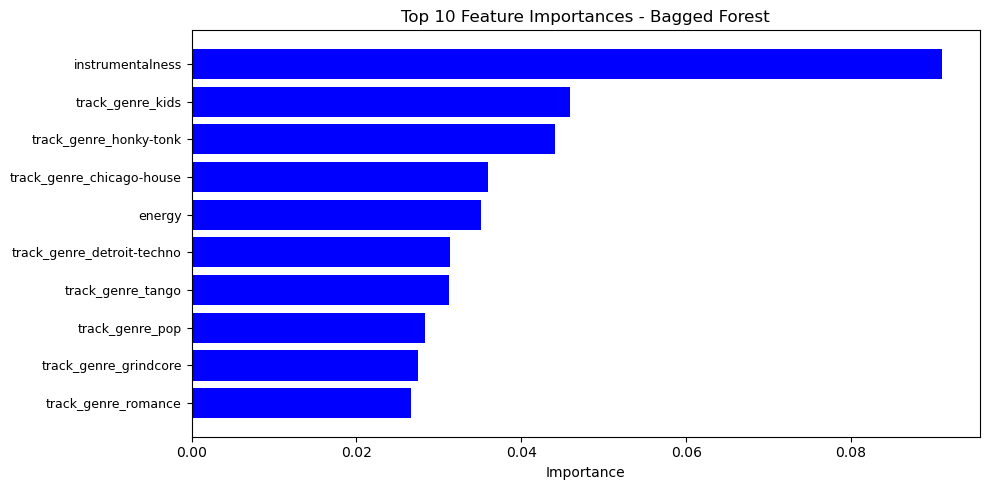

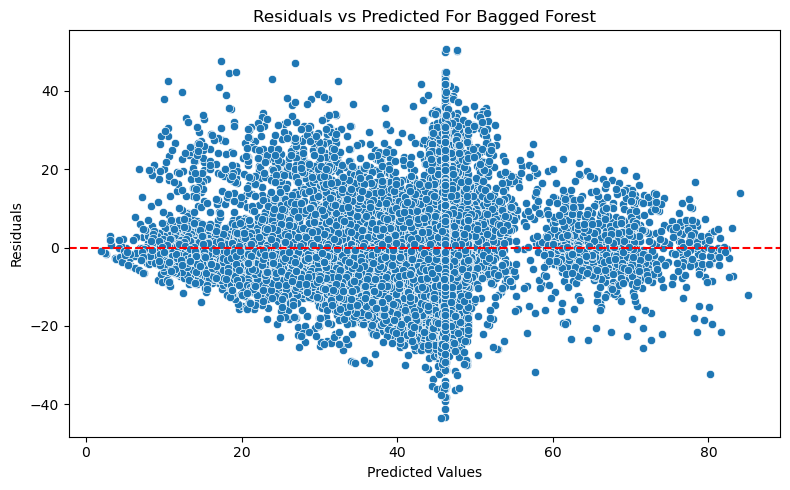

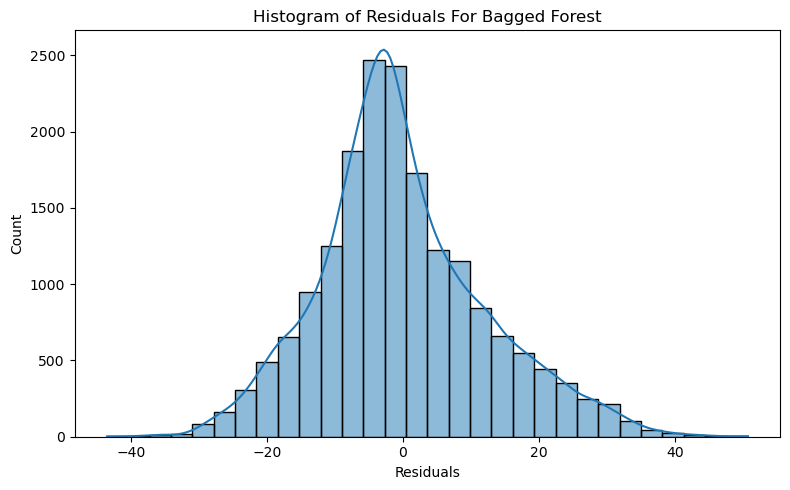

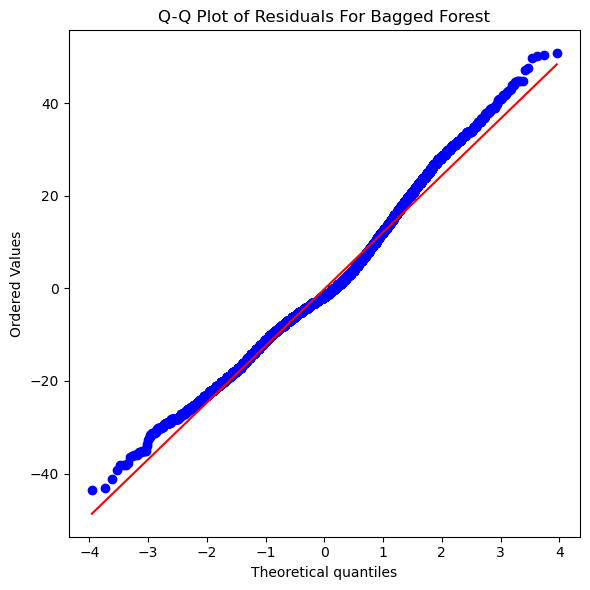

C:\Users\VincentX\AppData\Local\Temp\ipykernel_9212\4161607784.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="mako")


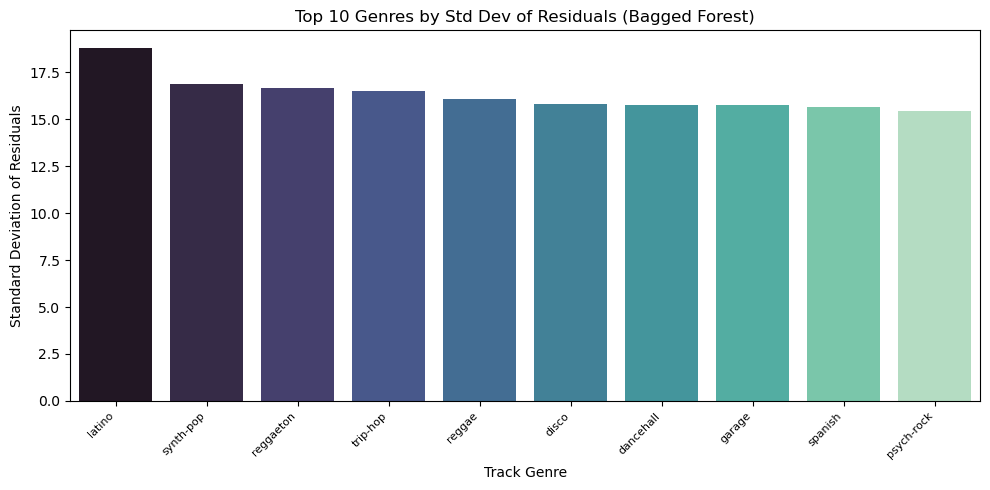

In [15]:
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', BaggingRegressor(
        estimator=DecisionTreeRegressor(
            max_depth=30,
            min_samples_leaf=4,
            random_state=42
        ),
        n_estimators=76,
        random_state=42,
        n_jobs=-1
    ))
])


pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

results = {
    "Train R²": r2_score(y_train, y_train_pred),
    "Test R²": r2_score(y_test, y_test_pred),
    "Test MSE": mean_squared_error(y_test, y_test_pred),
    "Train MSE": mean_squared_error(y_train, y_train_pred)
}

first_tree = pipeline.named_steps['model'].estimators_[0]
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = first_tree.feature_importances_
indices = np.argsort(importances)[-10:]  

top_indices_sorted = indices[np.argsort(importances[indices])]

print("Bagged Forest Results:")
for key, value in results.items():
    print(f"{key}: {value}")

plt.figure(figsize=(10, len(top_indices_sorted) * 0.5))  
plt.title("Top 10 Feature Importances - Bagged Forest")
plt.barh(range(len(top_indices_sorted)), importances[top_indices_sorted], align="center", color="blue")
plt.yticks(range(len(top_indices_sorted)), [feature_names[i] for i in top_indices_sorted], fontsize=9)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted For Bagged Forest")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals For Bagged Forest")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For Bagged Forest")
plt.tight_layout()
plt.show()

X_test_original = X.loc[X_test.index].copy()
X_test_original['residuals'] = residuals
X_test_original['predicted'] = y_test_pred
X_test_original['actual'] = y_test.values

genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)

top10_genre_std = genre_std.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="mako")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (Bagged Forest)")
plt.ylabel("Standard Deviation of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**LightGBM with Bayesian Optimization (6 Hour Run)** 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

C:\Users\xayas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\xayas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Best Parameters: OrderedDict([('model__colsample_bytree', 0.5), ('model__learning_rate', 0.03), ('model__max_depth', 60), ('model__min_child_samples', 15), ('model__n_estimators', 1600), ('model__num_leaves', 360), ('model__reg_alpha', 1.0), ('model__reg_lambda', 0.5), ('model__subsample', 0.9)])
Train R^2: 0.9537944968705734
Test R^2: 0.7036681342102407
Test MSE: 94.53699398200622


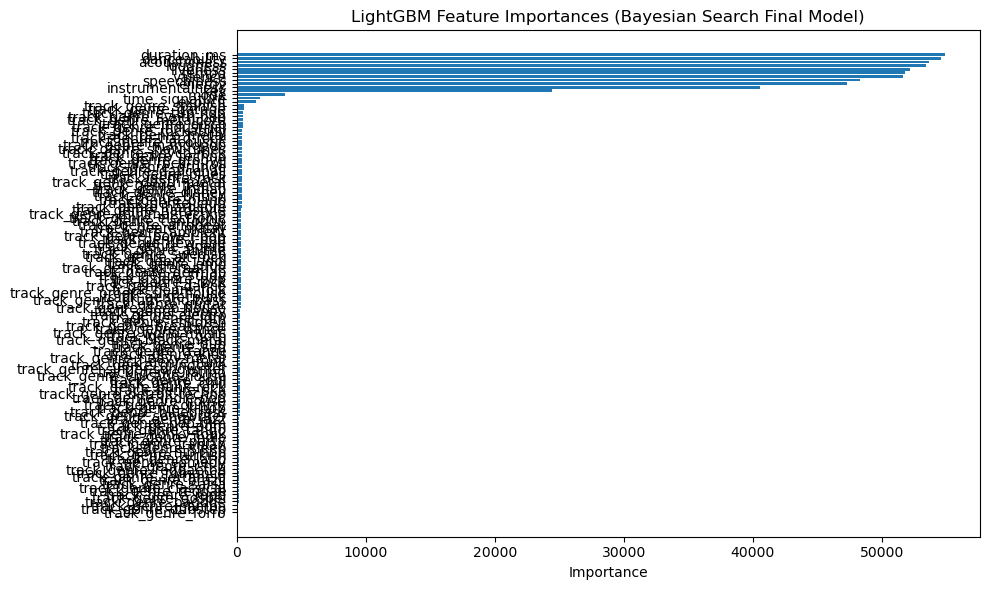

In [ ]:
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LGBMRegressor(objective='regression', random_state=42, n_jobs=-1))
])

search_space = {
    'model__num_leaves': Integer(340, 360),
    'model__max_depth': Integer(40, 60),
    'model__learning_rate': Real(0.03, 0.10, prior='log-uniform'),
    'model__n_estimators': Integer(1400, 1600),
    'model__min_child_samples': Integer(15, 20),
    'model__subsample': Real(0.9, 1.0),
    'model__colsample_bytree': Real(0.2, 0.5),
    'model__reg_alpha': Real(1.0, 10.0, prior='log-uniform'),
    'model__reg_lambda': Real(0.5, 5.0, prior='log-uniform')
}

opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=30,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

opt.fit(X_train, y_train)

best_pipeline = opt.best_estimator_
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

print("Best Parameters:", opt.best_params_)
print("Train R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

lgbm_model = best_pipeline.named_steps['model']
ohe = best_pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = lgbm_model.feature_importances_
top_indices = np.argsort(importances)[-10:]  
top_indices_sorted = top_indices[np.argsort(importances[top_indices])]  

plt.figure(figsize=(10, 5))
plt.title("Top 10 LightGBM Feature Importances (Bayesian Search Final Model)")
plt.barh(range(len(top_indices_sorted)), importances[top_indices_sorted], align="center", color="blue")
plt.yticks(range(len(top_indices_sorted)), [feature_names[i] for i in top_indices_sorted], fontsize=9)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Winning Model: LightGBM**

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2798
[LightGBM] [Info] Number of data points in the train set: 73187, number of used features: 128
[LightGBM] [Info] Start training from score 40.433615
Train R^2: 0.9787177111964703
Test R^2: 0.7020088581668258
Train MSE: 6.819250529766482
Test MSE: 95.06634295671988


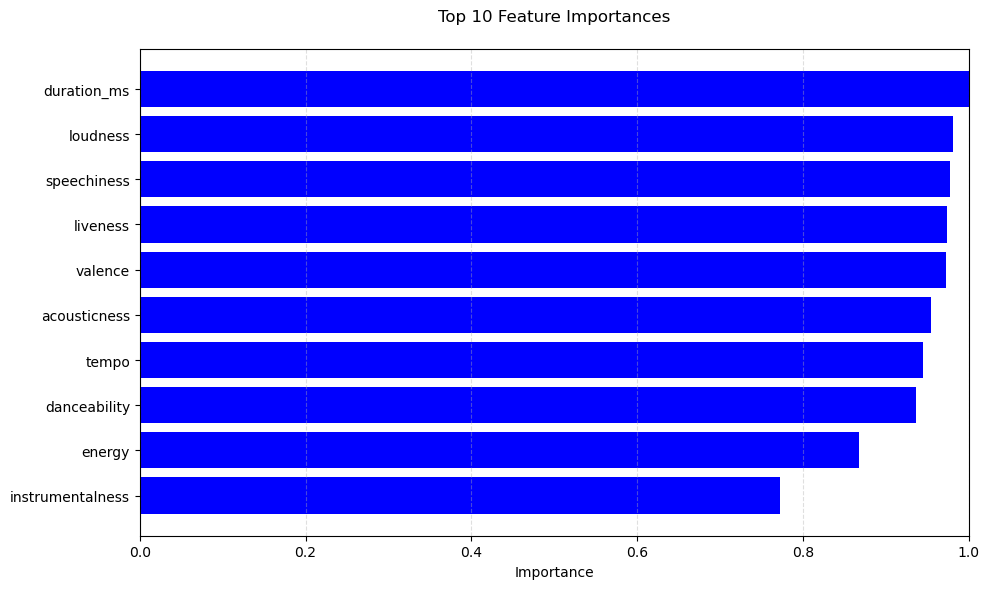

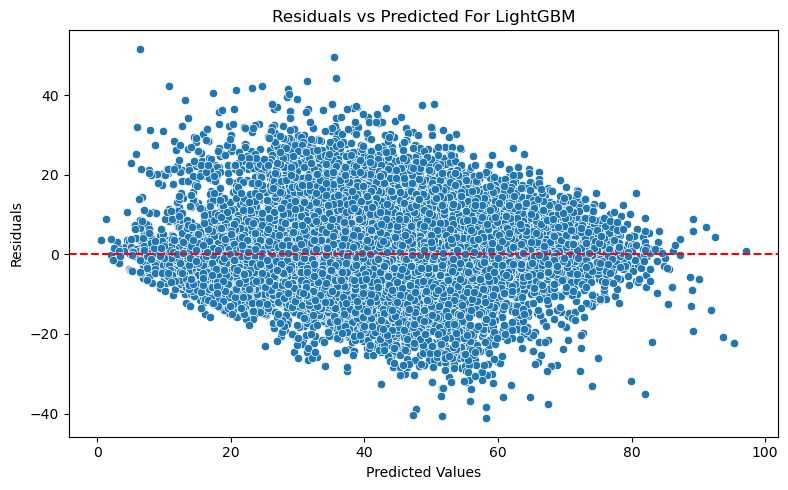

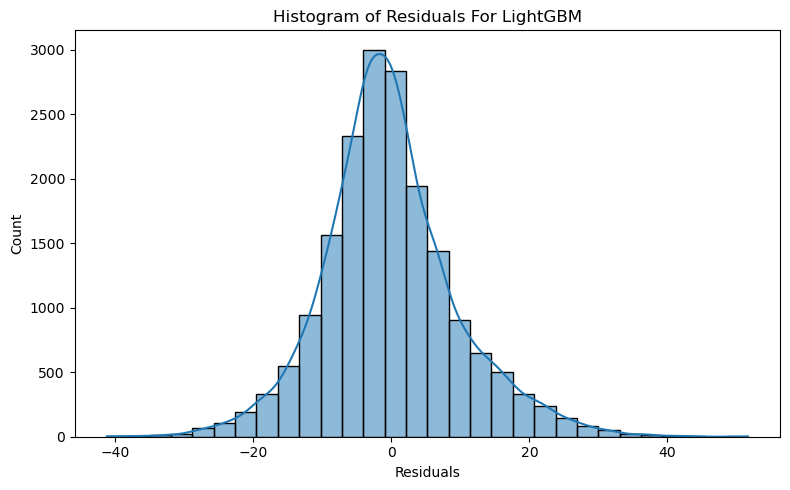

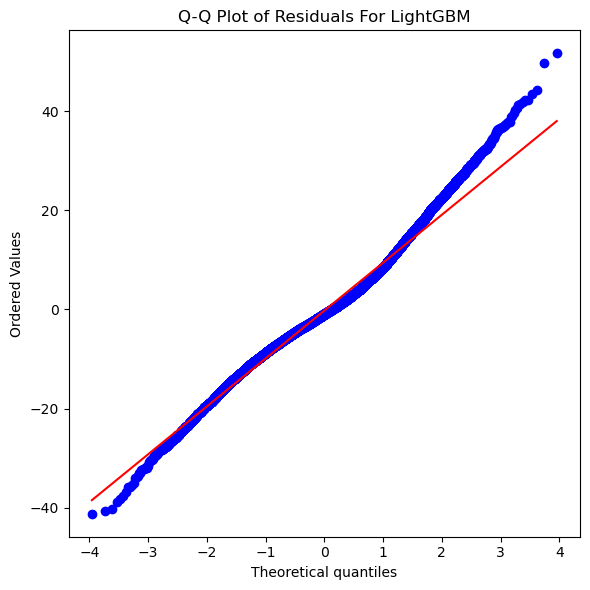

C:\Users\VincentX\AppData\Local\Temp\ipykernel_14200\1042701055.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="viridis")


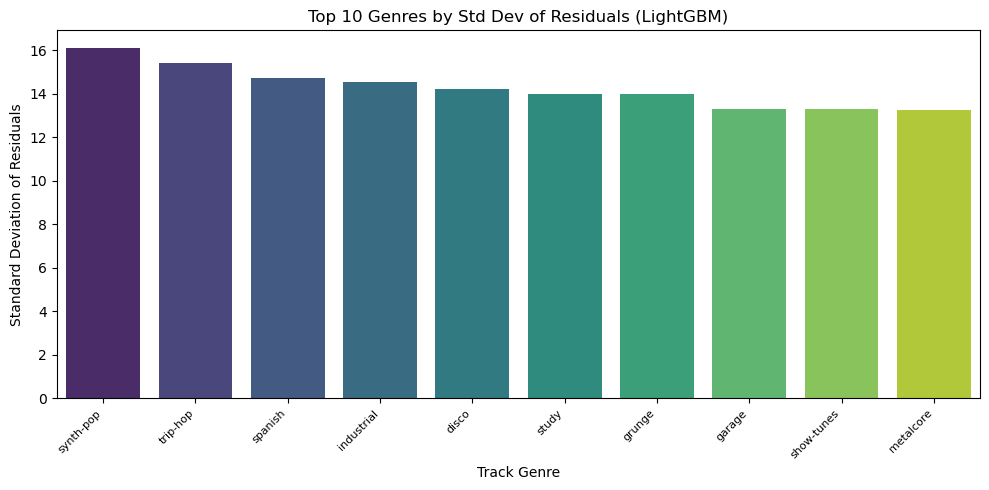

In [7]:
df = pd.read_csv("Cleaned_Dataset.csv")
df['explicit'] = df['explicit'].astype(int)

numerical_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]
categorical_features = ['track_genre']
all_features = numerical_features + categorical_features

X = df[all_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

model = LGBMRegressor(
    objective='regression',
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.42332053149109516,
    learning_rate=0.06674836528973682,
    max_depth=58,
    min_child_samples=17,
    n_estimators=1401,
    num_leaves=359,
    reg_alpha=3.7700247776742897,
    reg_lambda=3.779981995158376,
    subsample=0.9030923980367299
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print("Train R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

lgbm_model = pipeline.named_steps['model']
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_cat_names)

importances = lgbm_model.feature_importances_
indices = np.argsort(importances)[-10:]  
top_indices_sorted = indices[np.argsort(importances[indices])]

normalized_importances = importances / np.max(importances)

top_indices_sorted = np.argsort(normalized_importances)[-10:]  
top_features_sorted = [feature_names[i] for i in top_indices_sorted]
top_importances_sorted = normalized_importances[top_indices_sorted]

plt.figure(figsize=(10, 6))  
plt.barh(range(len(top_indices_sorted)), 
         top_importances_sorted, 
         align='center', 
         color='blue')  
plt.yticks(range(len(top_indices_sorted)), 
           top_features_sorted,
           fontsize=10)
plt.title('Top 10 Feature Importances', fontsize=12, pad=20)
plt.xlabel('Importance', fontsize=10)
plt.xlim(0, 1)   
plt.grid(axis='x', linestyle='--', alpha=0.4)  
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted For LightGBM")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals For LightGBM")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals For LightGBM")
plt.tight_layout()
plt.show()

X_test_original = X_test.copy()
X_test_original['residuals'] = residuals
X_test_original['predicted'] = y_test_pred
X_test_original['actual'] = y_test.values

X_test_original['track_genre'] = X.loc[X_test.index]['track_genre'].values

genre_std = X_test_original.groupby('track_genre')['residuals'].std().sort_values(ascending=False)
top10_genre_std = genre_std.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top10_genre_std.index, y=top10_genre_std.values, palette="viridis")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title("Top 10 Genres by Std Dev of Residuals (LightGBM)")
plt.ylabel("Standard Deviation of Residuals")
plt.xlabel("Track Genre")
plt.tight_layout()
plt.show()

**Artificial Neural Network**

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 554us/step - loss: 510.4274 - val_loss: 125.9398
Epoch 2/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - loss: 128.7220 - val_loss: 123.6714
Epoch 3/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - loss: 122.8508 - val_loss: 121.6272
Epoch 4/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - loss: 120.4571 - val_loss: 122.7088
Epoch 5/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - loss: 121.1619 - val_loss: 120.1546
Epoch 6/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - loss: 119.5430 - val_loss: 119.8554
Epoch 7/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - loss: 117.1873 - val_loss: 119.3853
Epoch 8/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - loss: 117.1422 - val_loss: 118.7954
Epoch 9/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - loss: 116.8517 - val_loss: 117.5853
Epoch 10/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - loss: 116.5689 - val_loss: 119.0120
Epoch 11/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - 

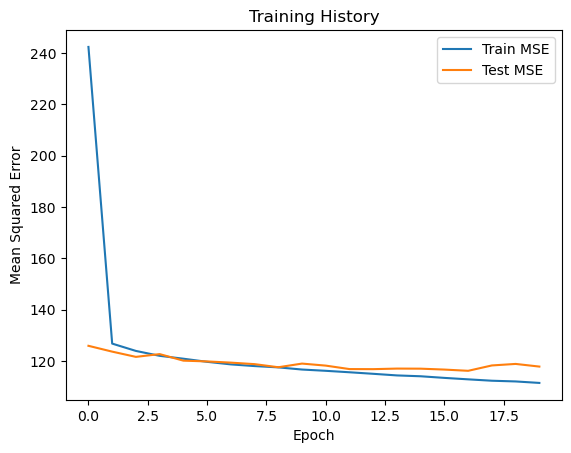

In [ ]:
df = pd.read_csv("spotify_final_cleaned.csv")

df_cleaned = df.drop(columns=[
    'Unnamed: 0', 'track_id', 'artists', 'album_name',
    'track_name', 'release_date'
])

X = df_cleaned.drop(columns=['popularity'])
y = df_cleaned['popularity']

categorical_features = ['explicit', 'track_genre']
numerical_features = X.drop(columns=categorical_features).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  
])

model.compile(optimizer='adam', loss='mse')  

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse:.2f}")

y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
print(f"Test R² Score: {r2:.4f}")

plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training History')
plt.legend()
plt.show()